<a href="https://colab.research.google.com/github/Badar97/Progetto_DataScience/blob/main/3-NetworkX/SocialNetworkAnalysisPt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SOCIAL NETWORK ANALYSIS 2**

## **0 Inizializzazione**

In [55]:
import networkx as nx
from networkx.algorithms.approximation import clique
import pandas as pd
import warnings
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import collections
from collections import defaultdict
from itertools import combinations
import scipy.sparse.linalg
warnings.filterwarnings('ignore')

In [56]:
%matplotlib inline 

In [57]:
url = "https://raw.githubusercontent.com/Badar97/Progetto_DataScience/main/3-NetworkX/arenas-jazz.edges"
req = requests.get(url)
req = req.text

split = req.split('\n')
splitted = list(split)

dati = pd.DataFrame(splitted, columns = ['archi'])
dati[['nodo1', 'nodo2']] = dati.archi.str.split(",", expand = True)
dati.drop(dati.tail(1).index,inplace=True)

archi = dati.drop(['archi'], axis=1)

In [58]:
G = nx.from_pandas_edgelist(archi, source='nodo1', target='nodo2')
nodes = list(G.nodes)
pos = nx.spring_layout(G)

In [59]:
def cli_graph(graph):  
  fig = plt.figure(figsize=(10,8))
  nx.draw(graph, alpha = 0.8, node_color = '#22B015', 
          with_labels= True, font_size = 16, 
          width = 0.2, edge_color ='black')
  fig.suptitle(f'Clique costituita da {len(graph)} nodi e {len(graph.edges)} archi', fontsize=20)
  plt.show()

In [60]:
# create ego network
def ego_net_top5(ego):
  ego_network = nx.ego_graph(G, ego)
  print("Nodes: ", len(ego_network.nodes))
  print("Edges: ", len(ego_network.edges))
  options = {'node_size': 2500, 'node_color': 'r'}
  plt.figure(figsize=(10,10))
  nx.draw(ego_network, pos, node_color='Green', node_size=800, 
          with_labels=True, edge_color="grey")
  nx.draw_networkx_nodes(ego_network, pos, nodelist=[ego], **options)
  plt.show()
  


## **3 Analisi delle Strutture**

### **3.1 Triadi**

Per l'analisi delle triadi possiamo dire poco, poichè non abbiamo i pesi negli archi, Si possono constatare solo 2 cose:
- il numero totale di triadi che vengono formate con il grafo sono: 1274196
- il numero di triadi complete, e quindi che per ogni nodi in una triade è collegato con gli altri, è: 17899

In [61]:
print(len(list(combinations(G.nodes, 3))))

1274196


In [62]:
nodi_tr = pd.DataFrame(nodes, columns = ['nodo'])

In [63]:
triadi = []
i = 1
# Per ogni triade viene estratto il sottografo associato
for triade in combinations(G.nodes,3):
  triade = list(triade)
  triade_graph = G.subgraph(triade)
  if triade_graph.number_of_edges()==3:
    triadi.append(triade_graph)
#triadi.sort(key=lambda triade: gradi, reverse=True)

In [64]:
len(triadi)

17899

In [65]:
tri_df = pd.DataFrame(triadi, columns = ['nodo_1', 'nodo_2', 'nodo_3'])

In [66]:
tri_df

nodo_1 nodo_2 nodo_3
0         12      1     10
1          1     13     10
2          1     14     10
3          1     15     10
4          1     17     10
...      ...    ...    ...
17894    129    136     47
17895    129     82     47
17896     82    136     47
17897     63    185    186
17898    129     82    136

[17899 rows x 3 columns]

### **3.2 Clique**

In [67]:
cliques = []
i = 1
for clique in nx.find_cliques(G):
  cliques.append(G.subgraph(clique))
print((f'Il grafo presenta in totale {len(cliques)} Clique'))

Il grafo presenta in totale 746 Clique


Text(0.5, 1.0, 'Distribuzioni delle dimensioni delle Clique')

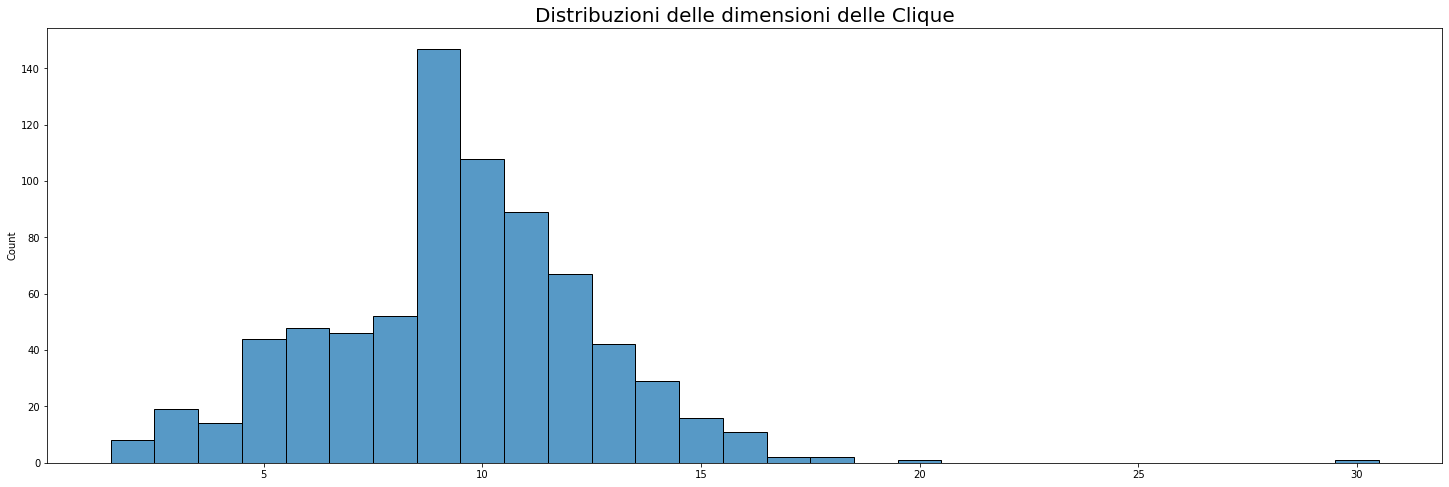

In [68]:
par_distr = []
for cl in cliques:
  par_distr.append(len(cl))
plt.figure(figsize=(25,8))
sns.histplot(par_distr, discrete=True)
plt.title("Distribuzioni delle dimensioni delle Clique", fontsize=20)

In [69]:
print(f'La clique massima del grafo ha {nx.graph_clique_number(G)} nodi')

La clique massima del grafo ha 30 nodi


In [70]:
cliq_fltr = [clq for clq in cliques if len(clq) >= 18]
print(f'Clique with n. nodes > 18: {len(cliq_fltr)}')
G_1 = cliq_fltr[0]
G_2 = cliq_fltr[1]
G_3 = cliq_fltr[2]
G_4 = cliq_fltr[3]
print(G_1)
print(G_2)
print(G_3)
print(G_4)

Clique with n. nodes > 18: 4
Graph with 30 nodes and 435 edges
Graph with 18 nodes and 153 edges
Graph with 18 nodes and 153 edges
Graph with 20 nodes and 190 edges


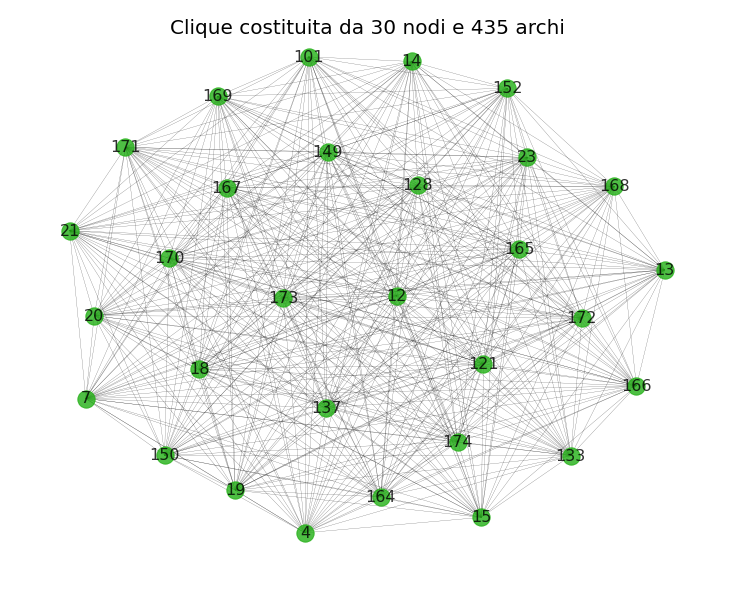

In [71]:
cli_graph(G_1)

In [72]:
nds = set(n for clq in cliq_fltr for n in clq)
h = G.subgraph(nds)

In [73]:
deg = nx.degree(h)
nds = [n for n in nds if deg[n] >= 45]

In [74]:
k = h.subgraph(nds)

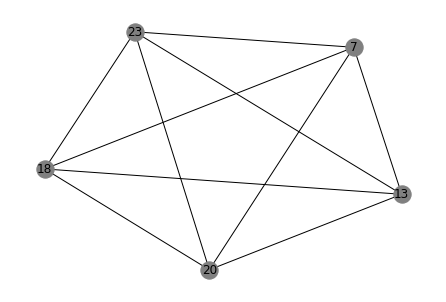

In [75]:
nx.draw(k, with_labels= True, node_color='grey')
#Qui si può fare un confronto tra il grado dei nodi delle 
#clique e il grado generale dei nodi

### **3.3 K-Core**

In [76]:
kcore=nx.k_core(G)

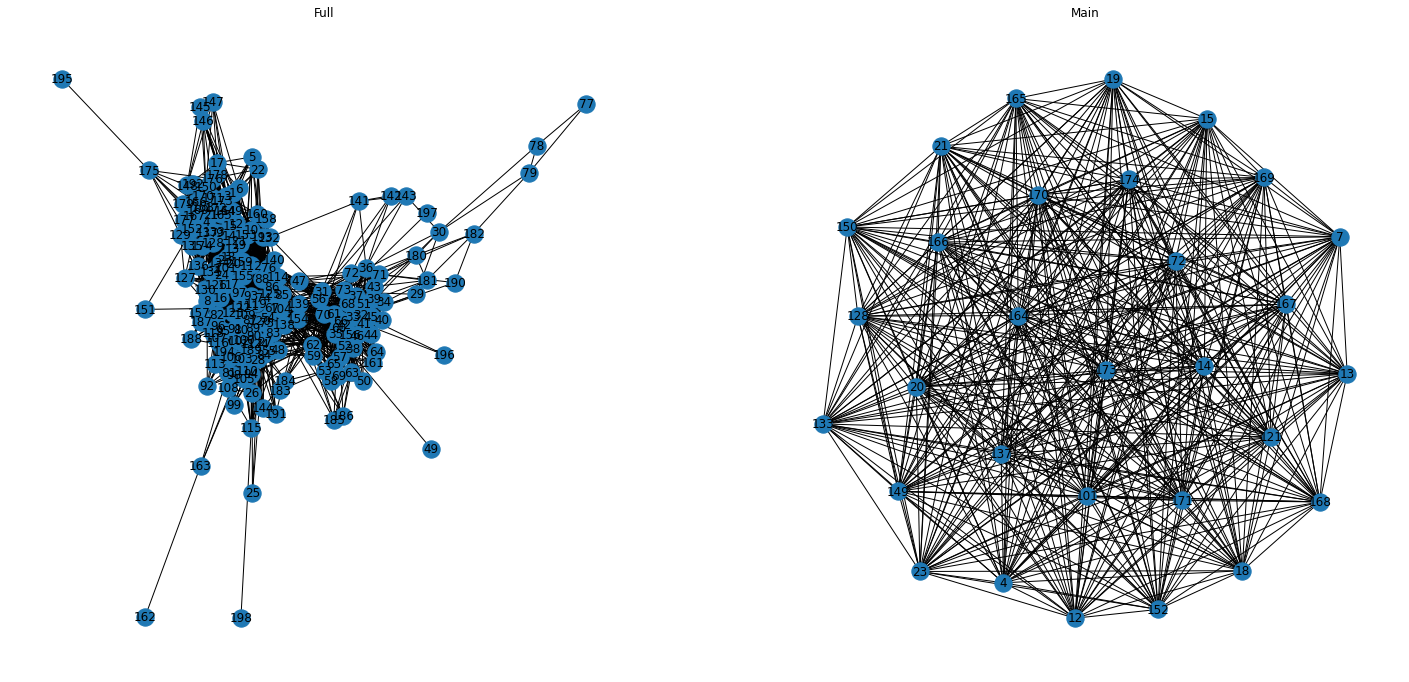

In [77]:
plt.figure(figsize=(25,12))
plt.subplot(121)
plt.title('Full')
nx.draw(G,with_labels=True)

plt.subplot(122)
plt.title('Main')
nx.draw(kcore,with_labels=True)

plt.show()

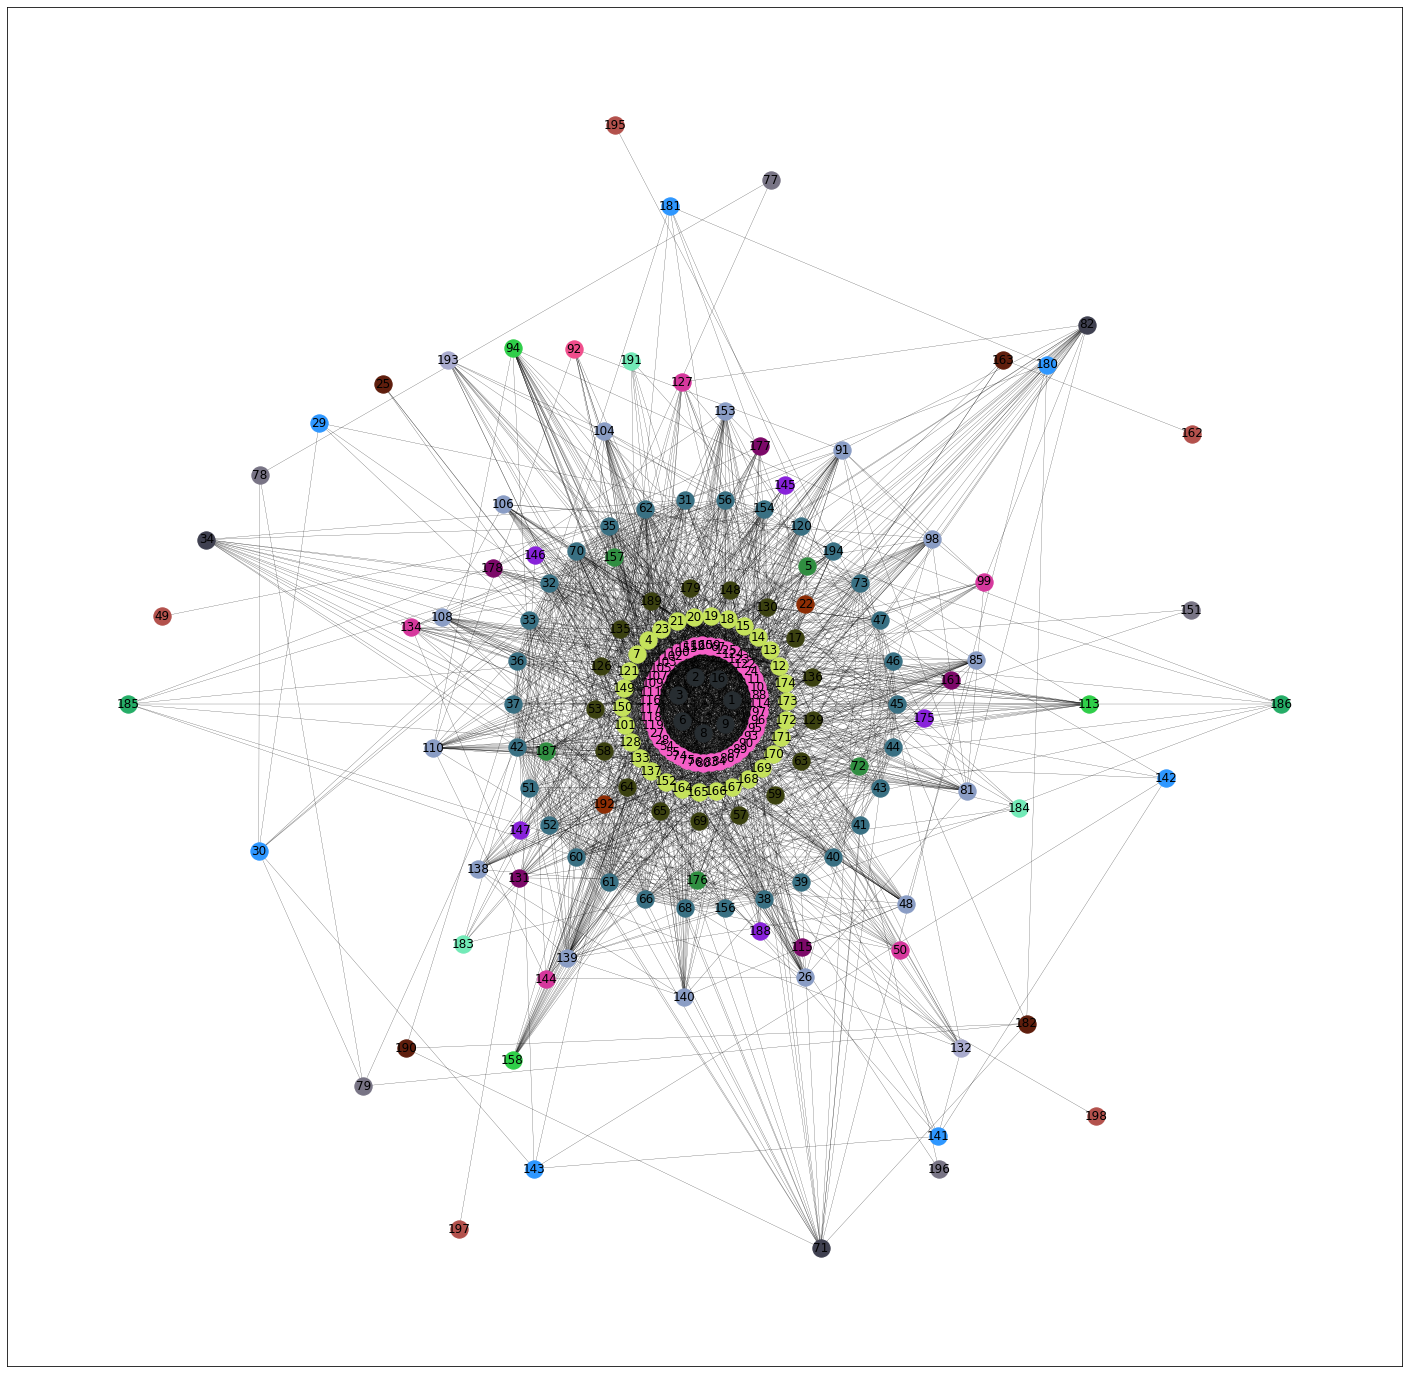

In [78]:
# build a dictionary of k-level with the list of nodes
kcores = defaultdict(list)
for n, k in nx.core_number(G).items():
    kcores[k].append(n)

# compute position of each node with shell layout
possh = nx.layout.shell_layout(G, list(kcores.values()))
#colors = {1: 'red', 2: 'green'}  # need to be improved, for demo
colors = {k: f"#{c[0]:02x}{c[1]:02x}{c[2]:02x}" 
          for k, c in 
          zip(kcores, np.random.randint(0, 256, (len(kcores), 3)))}

plt.figure(figsize=(25,25))
# draw nodes, edges and labels
for kcore, nodes in kcores.items():
    nx.draw_networkx_nodes(G,pos = possh, nodelist=nodes, node_color=colors[kcore])
nx.draw_networkx_edges(G,pos = possh, width=0.2)
nx.draw_networkx_labels(G,pos = possh)
plt.show()

In [79]:
numcore = []
for i in kcores:
  numcore.append(i)
kcores[0]
print(f'Il grafo ha {len(numcore)} core totali')

Il grafo ha 21 core totali


### **3.4 Ego Network**

Ego network dei nodi con grado maggiore 67, 7, 20, 23, 90.

Dopo aver visualizzato i vari grafi dei top5 in base al grado si puo notare che anche se il nodo 67 (grado 100) ha grado maggiore rispetto al nodo 7 (grado 96), gli ego network di questi 2 nodi messi a confronto mostrano che ci sono più archi e quindi più collegamenti nell'ego network del nodo 7 (archi 1517) che del nodo 67 (archi 1274)

Nodes:  101
Edges:  1274


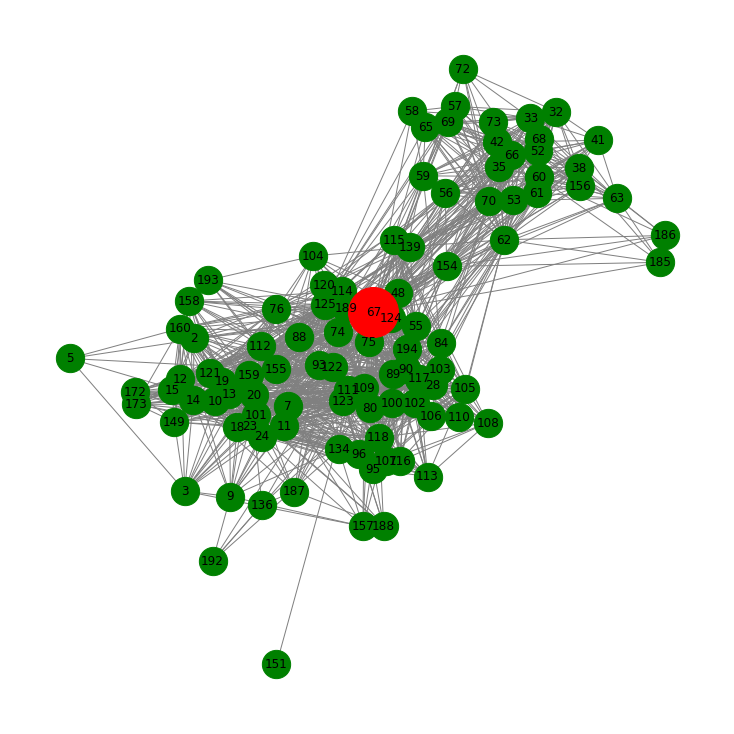

In [80]:
ego_net_top5('67')

Nodes:  97
Edges:  1517


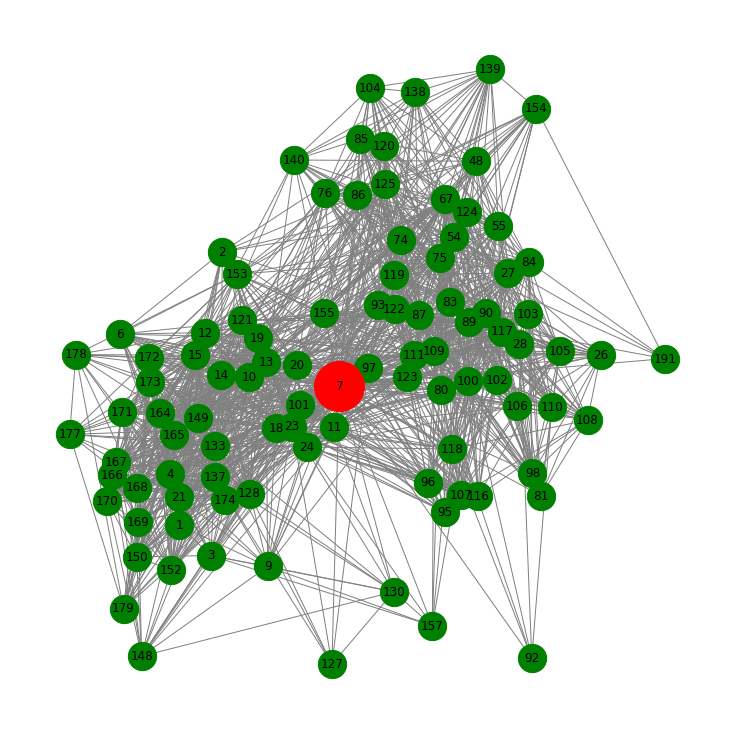

In [81]:
ego_net_top5('7')

Nodes:  76
Edges:  1196


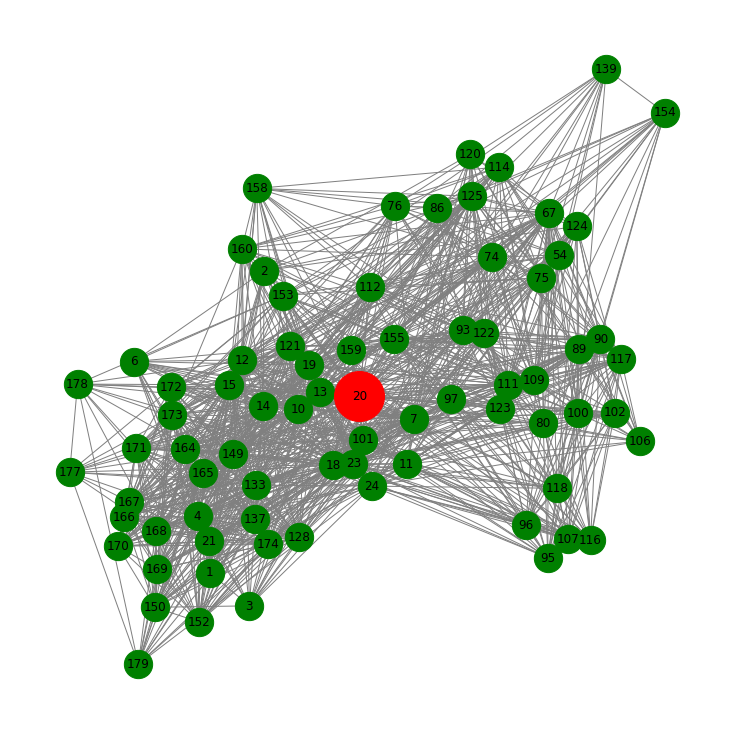

In [82]:
ego_net_top5('20')

Nodes:  75
Edges:  1052


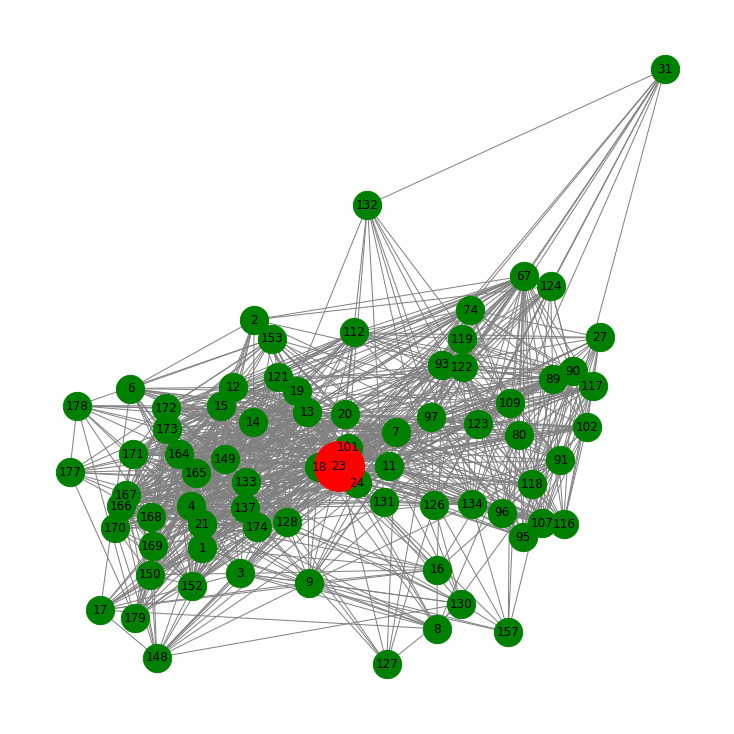

In [83]:
ego_net_top5('23')

Nodes:  63
Edges:  814


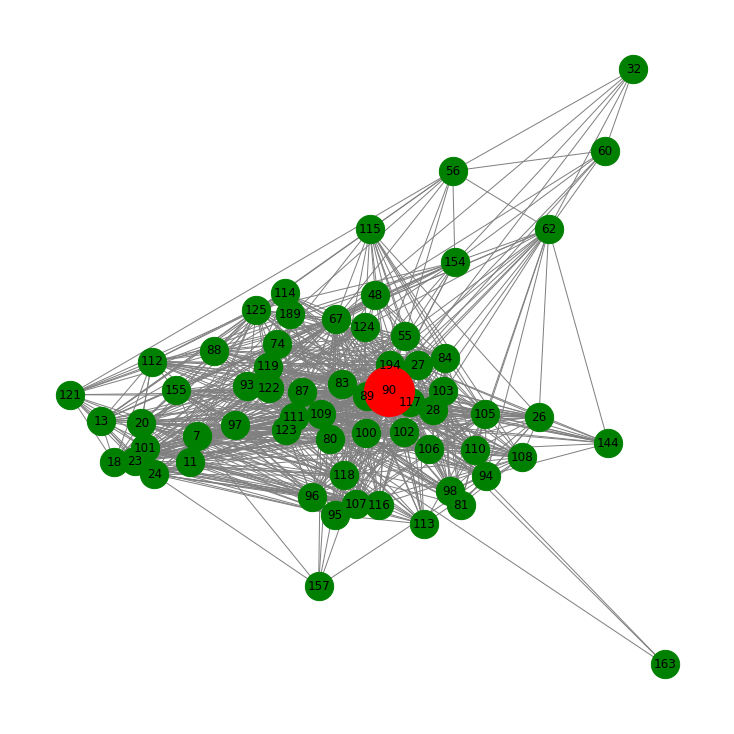

In [84]:
ego_net_top5('90')

### **3.5 Ponti**

I **Ponti** sono quegli archi che se rimossi creano due componenti connesse distinte. In questa rete, rappresentati in rosso, non sono di particolare interesse perché i ponti coinvolgono solo i nodi più estremi o le componenti piccole di 3 o 2 nodi isolati da quella principale, rappresentanti discipline molto specifiche e poco sviluppate; quindi, la loro rimozione non va a generare componenti connesse dalla fitta rete di nodi centrali.

In [85]:
bridges_g = nx.bridges(G)
bridges= []
for edge in bridges_g:
  bridges.append(edge)

graf = nx.from_edgelist(bridges)
bridge_node = list(graf.nodes)

ed = list(bridges)
print(f'Ci sono {len(ed)} ponti nel grafo')

Ci sono 5 ponti nel grafo


I ponti che ha il grafo sono i seguenti: 
[('115', '198'), ('35', '49'), ('70', '197'), ('163', '162'), ('175', '195')]


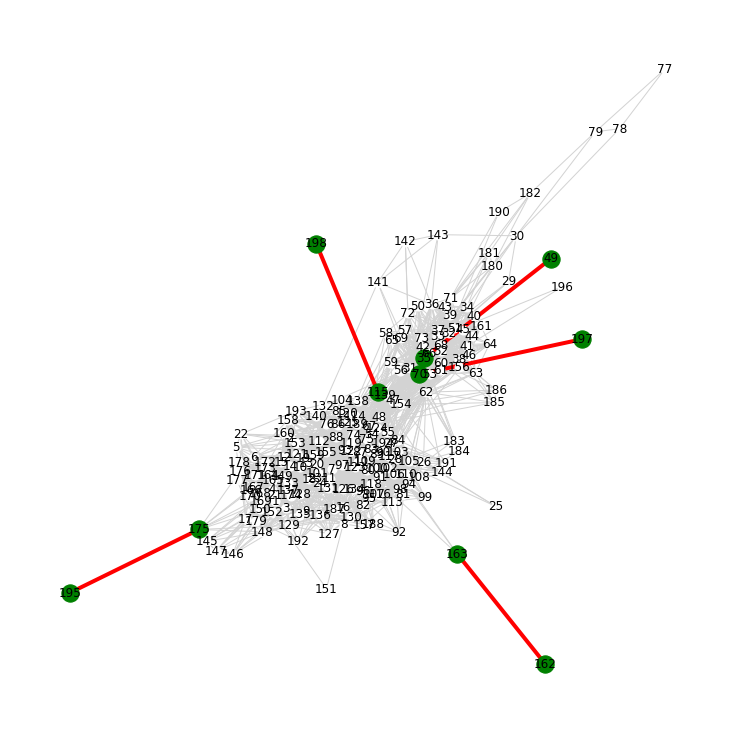

In [86]:
print(f'I ponti che ha il grafo sono i seguenti: \n{bridges}')
plt.figure(figsize=(10,10))
nx.draw(G, pos, node_color='white', node_size=80, with_labels=True, edge_color="lightgrey")
nx.draw_networkx_edges(G, pos, edgelist=bridges, edge_color="red", width=4)
nx.draw_networkx_nodes(G, pos, nodelist=bridge_node, node_color='green')
plt.show()